**Section 1: Import Required Libraries**

*We will start by importing the Python libraries that help us build and train machine learning models, handle data, and create plots for visualization.*

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import preprocessing layers individually
from tensorflow.keras.layers import Normalization, Rescaling, TextVectorization

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import datetime
from google.colab import files

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

**Section 2: Upload and Load Dataset**

*In this step, we will upload a dataset into our Colab environment and load it into Python. After that, we’ll take a quick look at the data to understand what it contains.*

In [3]:
uploaded = files.upload()  # Upload 'conduction_100.csv'


Saving conduction_100.csv to conduction_100.csv


In [4]:
data = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))

**Section 3: Define Inputs and Outputs**

*Now, we will identify the input features (the data the model will use to make predictions) and the output labels (what we want the model to predict). This is an important step for setting up a supervised machine learning task.*

In [5]:
# Define input and output columns
input_cols = ["T0", "T1", "T2", "T3", "T4", "T5"]
output_cols = ["q", "T1*", "T2*", "T3*", "T4*"]

**Section 4: Split Data into Training and Test Sets**

*Next, we will divide our dataset into training and testing sets. The training set is used to teach the model, while the testing set is used to see how well the model performs on new, unseen data. This helps us evaluate the model’s accuracy and reliability.*

In [6]:
train_dataset = data.sample(frac=0.8, random_state=42)
test_dataset = data.drop(train_dataset.index)

**Section 5: Normalize Data**

*Neural networks work better when all input features are on a similar scale. Normalization rescales the data so that values are neither too big nor too small. This helps the model learn faster, converge more reliably, and avoid giving more importance to features just because they have larger numbers.*

In [7]:
# Training stats (for normalization)
train_stats = train_dataset[input_cols].describe().transpose()

# Normalize function
def normalize(df):
    return (df - train_stats['mean']) / train_stats['std']

normed_train_data = normalize(train_dataset[input_cols])
normed_test_data = normalize(test_dataset[input_cols])

# Separate labels (outputs)
train_labels = train_dataset[output_cols]
test_labels = test_dataset[output_cols]

# Display normalized data
print("Normalized train data (first 5 rows):")
print(normed_train_data.head())
print("\nNormalized test data (first 5 rows):")
print(normed_test_data.head())

Normalized train data (first 5 rows):
          T0        T1        T2        T3        T4        T5
83 -1.484795 -1.479473 -1.464805 -1.470403 -1.477786 -1.474696
53 -0.058715 -0.056723 -0.075161 -0.073923 -0.071393 -0.076762
70  1.285299  1.287747  1.296013  1.300049  1.306125  1.301035
45 -0.425447 -0.421499 -0.440060 -0.427810 -0.408476 -0.414153
44 -0.068504 -0.071634 -0.078104 -0.084607 -0.095690 -0.086801

Normalized test data (first 5 rows):
          T0        T1        T2        T3        T4        T5
1   0.305988  0.320008  0.308706  0.324073  0.346100  0.325411
2   0.605269  0.619909  0.610583  0.620630  0.634990  0.627307
14  0.188258  0.189222  0.181581  0.181166  0.180514  0.168227
20  0.054053  0.060838  0.036587  0.049846  0.069062  0.050934
21  0.731338  0.754558  0.719676  0.746577  0.785096  0.760312


**Section 6: Build the Model**

*Now we will create our neural network. A neural network is made up of layers of neurons that process the input data. Each layer uses an activation function to help the network learn complex patterns. We’ll define the input layer (which takes our features), any hidden layers (which process the information), and the output layer (which makes predictions).*

In [8]:
num_outputs = 5

baseline_model = keras.Sequential([
    layers.Input(shape=(len(input_cols),)),  # Use Input layer instead of input_shape in Dense
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_outputs)  # 5 outputs
])

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
baseline_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,093 (35.52 KB)

 Trainable params: 9,093 (35.52 KB)

 Non-trainable params: 0 (0.00 B)

**Section 7: Define Callback and Training Parameters**

*Before training the model, we define training parameters like the number of epochs (how many times the model will see the full dataset) and callbacks (tools that help monitor or control training, like stopping early if the model stops improving). These settings help the model train efficiently and avoid overfitting.*

In [9]:
# Callback to print progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000

**Section 8: Example Prediction Before Training**

*Before we train the model, we can make a test prediction using random, untrained weights. This shows that initially, the model’s predictions are basically random and not accurate. It helps you understand how much the model improves after training.*

In [10]:
example_batch = normed_train_data[:5].values
example_result = baseline_model.predict(example_batch)
print("Example predictions (q, T1*, T2*, T3*, T4*):")
print(example_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Example predictions (q, T1*, T2*, T3*, T4*):
[[ 0.147  0.178 -0.074  0.382 -0.149]
 [ 0.01   0.009 -0.004  0.017 -0.005]
 [-0.115 -0.307  0.     0.081 -0.37 ]
 [ 0.044  0.051 -0.02   0.108 -0.045]
 [ 0.011  0.009 -0.005  0.02  -0.007]]


**Section 9: Setup TensorBoard**

*TensorBoard is a tool that lets us visualize and monitor our model’s training in real time. We can track metrics like loss and accuracy, see how the model improves over epochs, and spot problems early. Setting it up helps us understand what’s happening inside the neural network as it learns.*

In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

**Section 10: Train the Model**

*Now we will train (fit) the model on our data. During training, the model learns the patterns in the input features to make better predictions. We can also use a validation split to check the model’s performance on unseen data while training, and callbacks to monitor progress or stop training early if needed. This step is where the model actually “learns.”*

In [12]:
history = baseline_model.fit(
    normed_train_data.values, train_labels.values,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[tensorboard_callback, PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

**Section 11: Plot Training History**

*After training, we can visualize the model’s learning curves using metrics like MAE (Mean Absolute Error) and MSE (Mean Squared Error). These plots show how the model’s predictions improve over time and help us understand if the model is learning well or if it might be overfitting.*

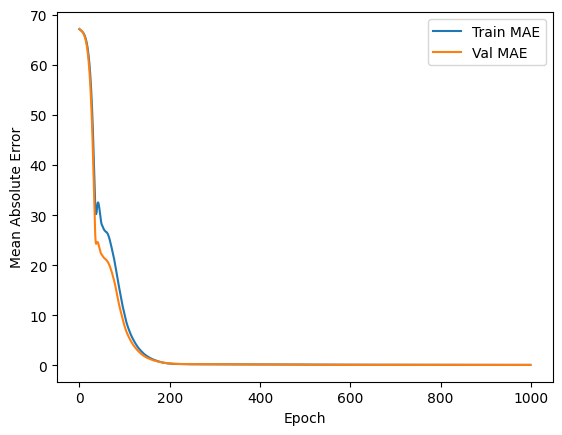

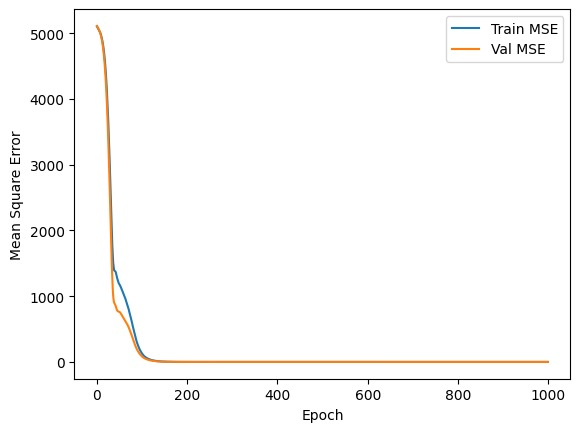

In [13]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # MAE
    plt.figure()
    plt.plot(hist['epoch'], hist['mae'], label='Train MAE')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

    # MSE
    plt.figure()
    plt.plot(hist['epoch'], hist['mse'], label='Train MSE')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()

plot_history(history)

**Section 12: Test Predictions and Scatter Plot**

*Finally, we will use the model to make predictions on the test data and compare them to the actual values. We can create a scatter plot to visualize how close the predictions are to the true values. This helps us see the model’s performance in a clear, visual way.*

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


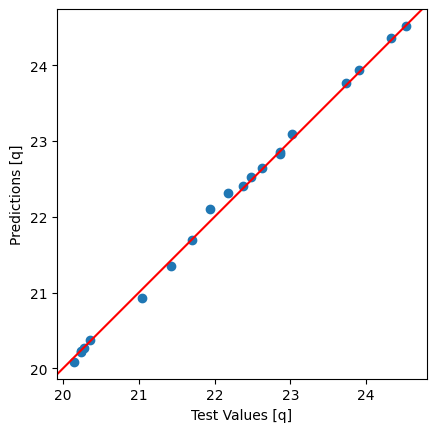

In [14]:
baseline_test_predictions = baseline_model.predict(normed_test_data.values)

plt.figure()
plt.scatter(test_labels['q'], baseline_test_predictions[:, 0])
plt.xlabel("Test Values [q]")
plt.ylabel("Predictions [q]")
plt.axis('equal')
plt.axis('square')
plt.plot([-100, 100], [-100, 100], 'r')
plt.show()

**Section 13: Prediction Error Histograms**

*We can also look at histograms of the prediction errors (the differences between predicted and actual values). This helps us see where the model is making bigger mistakes and understand its strengths and weaknesses for each output.*

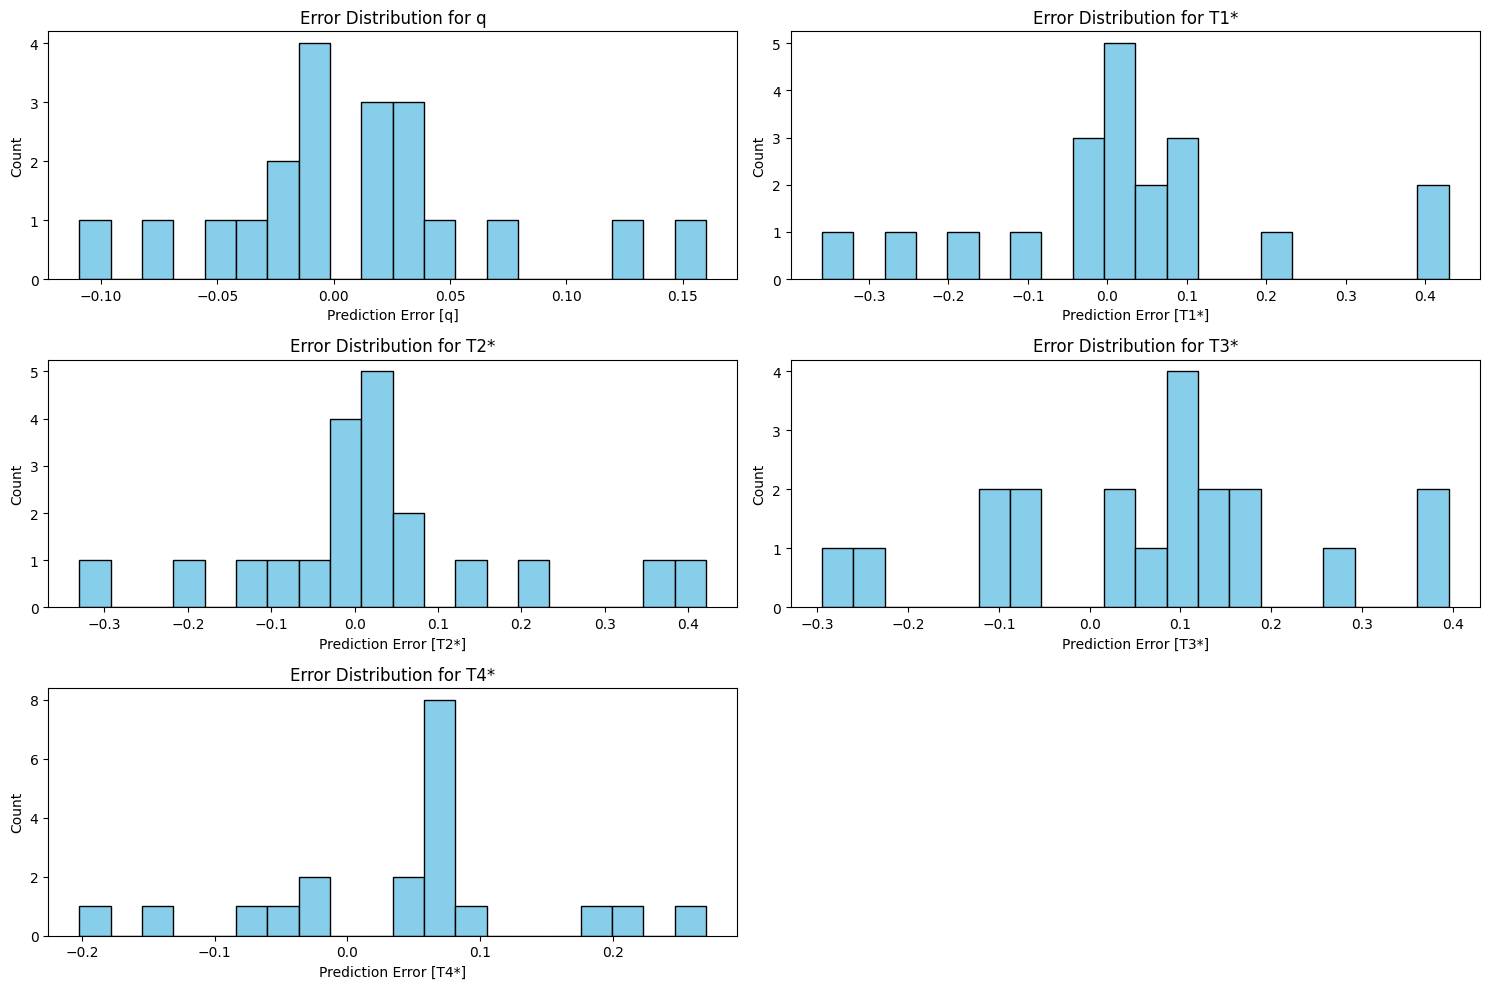

In [15]:
baseline_error = baseline_test_predictions - test_labels.values
output_names = output_cols

plt.figure(figsize=(15, 10))
for i, name in enumerate(output_names):
    plt.subplot(3, 2, i+1)
    plt.hist(baseline_error[:, i], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(f"Prediction Error [{name}]")
    plt.ylabel("Count")
    plt.title(f"Error Distribution for {name}")

plt.tight_layout()
plt.show()

**Section 14: Let's test what ML has learned!**

Use your input data as test to generate output data based on what Machine learning has learning in previous sections.

In [16]:
from google.colab import files
import io
import pandas as pd

# Upload new input CSV (with only T0–T5 columns)
uploaded_new = files.upload()
new_input = pd.read_csv(io.BytesIO(list(uploaded_new.values())[0]))

# Normalize and predict
normed_new = (new_input[input_cols] - train_stats['mean']) / train_stats['std']
preds = baseline_model.predict(normed_new.values)

# Show predictions
print(pd.DataFrame(preds, columns=output_cols))


Saving conduction_test.csv to conduction_test (1).csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
            q         T1*         T2*         T3*         T4*
0   80.456009  315.102356  311.139771  284.149475  223.810669
1  104.994942  412.221039  406.646423  372.152618  293.439636
2  108.359253  425.731323  419.885620  384.835144  303.486847
3  133.597656  524.562683  517.557251  474.800903  374.772949
4  138.928146  544.677551  537.232483  493.438171  389.569000
5  154.940765  607.435303  598.876587  550.727600  434.440186
6  181.400909  711.157104  700.913696  645.111816  508.628418
7  187.343979  734.126831  723.215210  666.370605  524.959595
8  214.259476  839.231750  826.478882  762.003418  600.058350
9  220.994492  865.257019  851.791626  785.848877  618.515259


**Section 15: Use ChatGPT to generate you required code-block:**

Type in the following text in ChatGPT:

"Write a code block based on the code above to generate a graph of actual value and predicted value".

You will see something like below:


import matplotlib.pyplot as plt

# Generate predictions on test data
baseline_test_predictions = baseline_model.predict(normed_test_data.values)

# Plot actual vs predicted for each output
plt.figure(figsize=(15, 10))

for i, name in enumerate(output_cols):
    plt.subplot(3, 2, i+1)
    plt.scatter(test_labels[name], baseline_test_predictions[:, i], color='blue', alpha=0.6)
    plt.plot([test_labels[name].min(), test_labels[name].max()],
             [test_labels[name].min(), test_labels[name].max()],
             'r--', linewidth=2)  # reference line y=x
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted for {name}")
    plt.grid(True)

plt.tight_layout()
plt.show()
"

You just need to copy this code and paste below usign "+Code"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


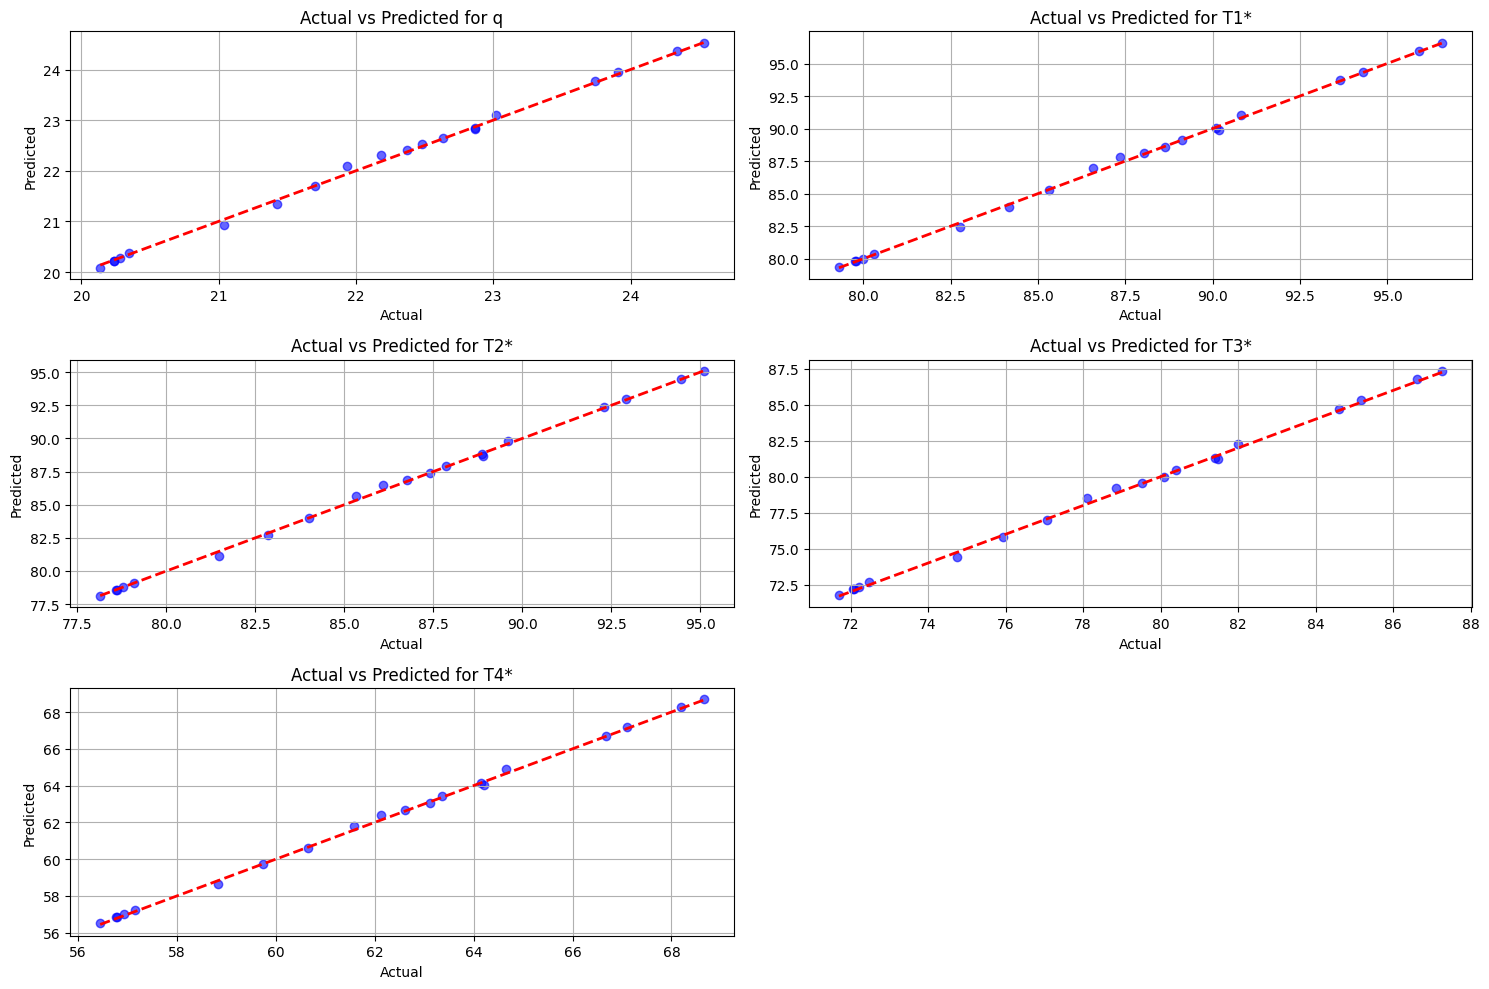

In [17]:


import matplotlib.pyplot as plt

# Generate predictions on test data
baseline_test_predictions = baseline_model.predict(normed_test_data.values)

# Plot actual vs predicted for each output
plt.figure(figsize=(15, 10))

for i, name in enumerate(output_cols):
    plt.subplot(3, 2, i+1)
    plt.scatter(test_labels[name], baseline_test_predictions[:, i], color='blue', alpha=0.6)
    plt.plot([test_labels[name].min(), test_labels[name].max()],
             [test_labels[name].min(), test_labels[name].max()],
             'r--', linewidth=2)  # reference line y=x
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted for {name}")
    plt.grid(True)

plt.tight_layout()
plt.show()
